In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np

In [2]:
# demand_bookings_df = pd.read_csv('./hotel_bookings.csv')
# demand_bookings_df.rename(columns = {
#     'adults': 'no_of_adults',
#     'children': 'no_of_children',
#     'stays_in_weekend_nights': 'no_of_weekend_nights',
#     'stays_in_week_nights': 'no_of_week_nights',
#     'meal': 'type_of_meal_plan',
#     'required_car_parking_spaces': 'required_car_parking_space',
#     'reserved_room_type': 'room_type_reserved',
#     'lead_time': 'lead_time',
#     'arrival_date_year': 'arrival_year',
#     'arrival_date_month': 'arrival_month',
#     'arrival_date_day_of_month': 'arrival_date',
#     'market_segment': 'market_segment_type',
#     'is_repeated_guest': 'repeated_guest',
#     'previous_cancellations': 'no_of_previous_cancellations',
#     'previous_bookings_not_canceled': 'no_of_previous_bookings_not_canceled',
#     'adr': 'avg_price_per_room',
#     'total_of_special_requests': 'no_of_special_requests',
#     'is_canceled': 'booking_status'
# }, inplace=True)

# demand_bookings_df['arrival_month'] = demand_bookings_df['arrival_month'].map({
#     'January': 1, 'February': 2, 'March': 3, 'April': 4,
#     'May': 5, 'June': 6, 'July': 7, 'August': 8,
#     'September': 9, 'October': 10, 'November': 11, 'December': 12
# })

# demand_bookings_df['type_of_meal_plan'] = \
#     demand_bookings_df['type_of_meal_plan'].map({
#         'BB': 0, 'HB': 2, 'SC': 1, 'Undefined': 1, 'FB': 3
#     })

# demand_bookings_df['market_segment_type'] = \
#     demand_bookings_df['market_segment_type'].map({
#         "'Online TA": 1, "Offline TA/TO": 0, "Corporate": 2, "Complementary": 4, "Aviation": 3
#     })

# demand_bookings_df['room_type_reserved'] = \
#     demand_bookings_df['room_type_reserved'].map({
#         'A':  0, 'D':  1, 'E':  3, 'F':  2, 'G':  4, 'B':  5, 'C':  6
#     })

# demand_bookings_df['market_segment_type'].fillna(5, inplace=True)
# demand_bookings_df['room_type_reserved'].fillna(7, inplace=True)

In [3]:
train = pd.read_csv('./train.csv').drop('id',axis=1)
origin = pd.read_csv('./archive/train__dataset.csv')
train = pd.concat([train,origin],axis=0).drop_duplicates().reset_index(drop=True) # demand_bookings_df
test = pd.read_csv('./test.csv').drop('id',axis=1)

In [4]:
train.columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

In [5]:
train[(train['lead_time'] < 10) & (train['avg_price_per_room'] < 13)]['booking_status'].value_counts()

0    604
1     15
Name: booking_status, dtype: int64

In [6]:
train = train[(train.lead_time > 0) | ((train.lead_time == 0) & (train.booking_status == 0))]
train = train[train.no_of_adults != 0] # 성인이 없는 경우
# train = train[train.no_of_children < 5] # 해당경우 아이의수를 5로 수정
train = train[train.no_of_weekend_nights < 7]
# train = train[train.avg_price_per_room < 5]
# 주말수와 주중수가 말이 안되는경우 색출
# 충성고객 레이블

6


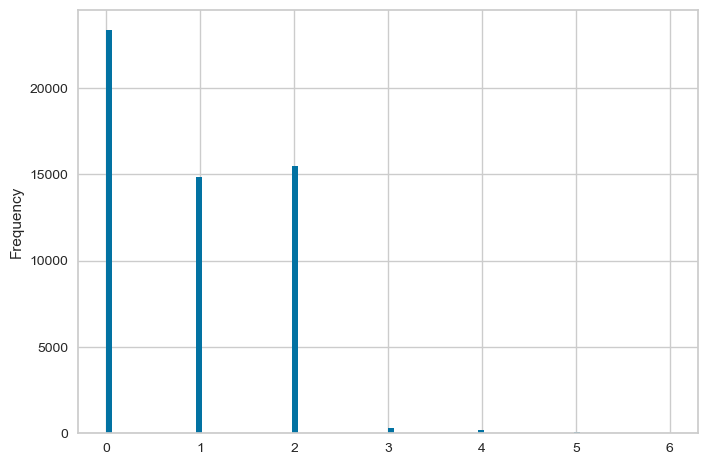

In [33]:
train.no_of_weekend_nights.plot.hist(bins=100)
print(train.no_of_weekend_nights.max())

17


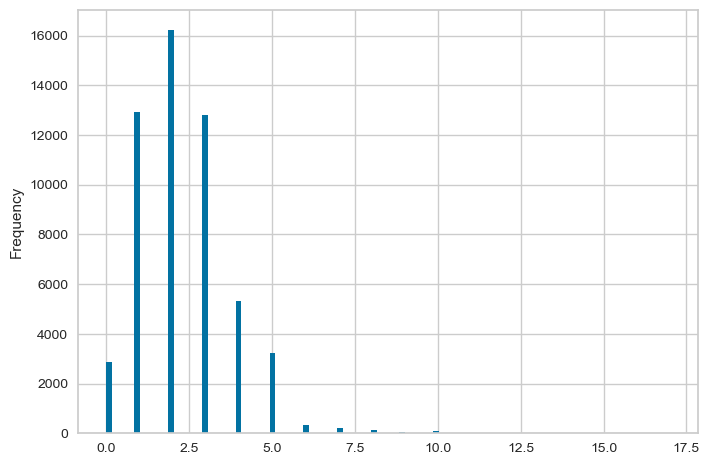

In [32]:
train.no_of_week_nights.plot.hist(bins=100)
print(train.no_of_week_nights.max())

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = np.array(train['avg_price_per_room']).reshape(-1,1)
scaler.fit(data)
data = scaler.transform(data)
train['avg_price_per_room'] = data

data = np.array(train['lead_time']).reshape(-1,1)
scaler.fit(data)
data = scaler.transform(data)
train['lead_time'] = data

In [8]:
train['instance'] = (train['lead_time']+train['avg_price_per_room'])**1/2
test['instance'] = (test['lead_time']+test['avg_price_per_room'])**1/2

In [9]:
train[train['instance'] < 0.05]['booking_status'].value_counts()

0    841
1     21
Name: booking_status, dtype: int64

In [10]:
tp = []
for i in train['instance']:
    if i < 0.05:
        tp.append(1)
    else:
        tp.append(0)
train['instance'] = tp

tp = []
for i in test['instance']:
    if i < 0.05:
        tp.append(1)
    else:
        tp.append(0)
test['instance'] = tp

C:\Users\user\AppData\Local\Temp\ipykernel_21984\3765977564.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((train[train['booking_status'] == 0]['lead_time']+train[train['booking_status'] == 0]['avg_price_per_room']), label = 'Normal', color = 'b', bins = 100)
C:\Users\user\AppData\Local\Temp\ipykernel_21984\3765977564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see


<AxesSubplot: ylabel='Density'>

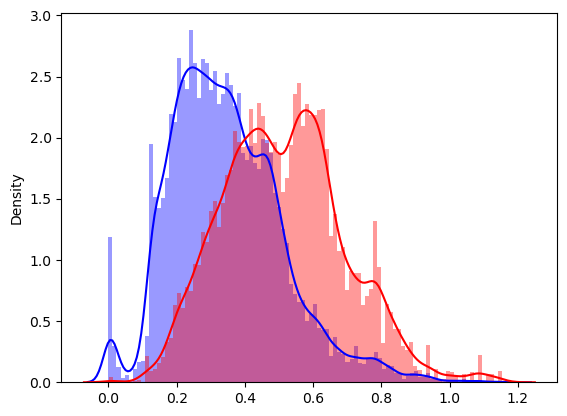

In [11]:
import seaborn as sns
sns.distplot((train[train['booking_status'] == 0]['lead_time']+train[train['booking_status'] == 0]['avg_price_per_room']), label = 'Normal', color = 'b', bins = 100)
sns.distplot((train[train['booking_status'] == 1]['lead_time']+train[train['booking_status'] == 1]['avg_price_per_room']), label = 'Normal', color = 'r', bins = 100)

---

In [12]:
train[train.booking_status == 0]['no_of_previous_cancellations'].value_counts()

0     34011
1       237
2        75
3        72
11       35
4        21
5         6
6         3
13        2
8         1
Name: no_of_previous_cancellations, dtype: int64

In [13]:
train[train.booking_status == 1]['no_of_previous_bookings_not_canceled'].value_counts()

0     19784
1         4
4         1
12        1
Name: no_of_previous_bookings_not_canceled, dtype: int64

In [14]:
train[train.booking_status == 1]['repeated_guest'].value_counts()

0    19776
1       14
Name: repeated_guest, dtype: int64

In [15]:
train[train.booking_status == 1].no_of_special_requests.value_counts()

0    13824
1     4594
2     1367
3        5
Name: no_of_special_requests, dtype: int64

---

In [16]:
train[train.avg_price_per_room > 150].booking_status.value_counts()

Series([], Name: booking_status, dtype: int64)

In [17]:
tp1 = []
for i in train.avg_price_per_room:
    if i < 10:
        tp1.append(0)
    elif i >= 10 and i < 100:
        tp1.append(1)
    else:
        tp1.append(2)
train['expensive'] = tp1

tp2 = []
for i in test.avg_price_per_room:
    if i < 10:
        tp2.append(0)
    elif i >= 10 and i < 100:
        tp2.append(1)
    else:
        tp2.append(2)
test['expensive'] = tp2

In [18]:
cols = train.columns
train = train.loc[:,cols]
train['guest'] = train['no_of_adults'] + train['no_of_children']
test['guest'] = test['no_of_adults'] + test['no_of_children']

In [19]:
drop_target = ['arrival_year','arrival_date',
              ]
train = train.drop(drop_target,axis=1)
test = test.drop(drop_target,axis=1)

In [20]:
train.booking_status.value_counts()

0    34463
1    19790
Name: booking_status, dtype: int64

In [21]:
train.columns

Index(['no_of_adults', 'no_of_weekend_nights', 'no_of_week_nights',
       'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved',
       'lead_time', 'arrival_month', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'instance', 'expensive', 'guest'],
      dtype='object')

In [22]:
test.columns

Index(['no_of_adults', 'no_of_weekend_nights', 'no_of_week_nights',
       'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved',
       'lead_time', 'arrival_month', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'instance', 'expensive',
       'guest'],
      dtype='object')

In [23]:
from pycaret import classification
classification.setup(session_id=41,data=train,target='booking_status')

,Description,Value
0,session_id,41
1,Target,booking_status
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(54253, 18)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,14
8,Ordinal Features,False
9,High Cardinality Features,False


(5,
 'lightgbm',
 False,
 10,
 None,
 StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
 {'lr': <pycaret.containers.models.classification.LogisticRegressionClassifierContainer at 0x22d479fbbe0>,
  'knn': <pycaret.containers.models.classification.KNeighborsClassifierContainer at 0x22d479fbd30>,
  'nb': <pycaret.containers.models.classification.GaussianNBClassifierContainer at 0x22d479fbd90>,
  'dt': <pycaret.containers.models.classification.DecisionTreeClassifierContainer at 0x22d479fbf70>,
  'svm': <pycaret.containers.models.classification.SGDClassifierContainer at 0x22d479fbfa0>,
  'rbfsvm': <pycaret.containers.models.classification.SVCClassifierContainer at 0x22d42cee580>,
  'gpc': <pycaret.containers.models.classification.GaussianProcessClassifierContainer at 0x22d42cee700>,
  'mlp': <pycaret.containers.models.classification.MLPClassifierContainer at 0x22d42cee7c0>,
  'ridge': <pycaret.containers.models.classification.RidgeClassifierContainer at 0x22d42ceea60>,
  'rf':

In [24]:
best = classification.compare_models(sort='AUC',n_select=4,fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8277,0.8981,0.7305,0.7785,0.7537,0.6214,0.6221,1.0530
catboost,CatBoost Classifier,0.8282,0.8974,0.7269,0.7819,0.7533,0.6218,0.6229,2.1980
lightgbm,Light Gradient Boosting Machine,0.8263,0.8959,0.7258,0.7781,0.7510,0.6178,0.6188,0.0920
gbc,Gradient Boosting Classifier,0.8174,0.8828,0.6946,0.7763,0.7331,0.5950,0.5972,0.7160
ada,Ada Boost Classifier,0.8001,0.8722,0.6982,0.7349,0.7161,0.5620,0.5625,0.2100
rf,Random Forest Classifier,0.7974,0.8595,0.6852,0.7355,0.7095,0.5542,0.5551,0.5500
lr,Logistic Regression,0.7886,0.8550,0.6543,0.7318,0.6908,0.5309,0.5329,0.9990
lda,Linear Discriminant Analysis,0.7863,0.8519,0.6518,0.7278,0.6877,0.5260,0.5279,0.2500
et,Extra Trees Classifier,0.7664,0.8092,0.6456,0.6882,0.6661,0.4868,0.4875,0.7960
knn,K Neighbors Classifier,0.7606,0.8075,0.6435,0.6775,0.6600,0.4755,0.4760,2.6600


In [25]:
best_tune = [classification.tune_model(i) for i in best]

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:12:50
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Fold,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


KeyboardInterrupt: 

In [ ]:
best_tune

In [ ]:
best_tune[0].get_params()

In [ ]:
best_tune[1].get_params()

In [ ]:
import catboost
params = best_tune[1].get_params()
cat = catboost.CatBoostClassifier(**params)
cat.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_cat = cat.predict_proba(test)

In [ ]:
import xgboost
params = best_tune[0].get_params()
xgb = xgboost.XGBClassifier(**params)
xgb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_xgb = xgb.predict_proba(test)

In [ ]:
import lightgbm
params = best_tune[2].get_params()
lgb = lightgbm.LGBMClassifier(**params)
lgb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_lgb = lgb.predict_proba(test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
params = best_tune[3].get_params()
gb = GradientBoostingClassifier(**params)
gb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_ggb = gb.predict_proba(test)

In [ ]:
proba = [proba_cat,proba_xgb,proba_lgb,proba_ggb]
proba = [[j[1] for j in i] for i in proba]

In [ ]:
import matplotlib.pyplot as plt
plt.barh(cat.feature_names_,cat.feature_importances_)

In [ ]:
plt.barh(cat.feature_names_,xgb.feature_importances_)

In [ ]:
plt.barh(cat.feature_names_,lgb.feature_importances_)

In [ ]:
plt.barh(cat.feature_names_,gb.feature_importances_)

In [ ]:
best_tune

In [ ]:
sub = pd.read_csv('./sample_submission.csv')
sub['booking_status'] = 0.1*np.array(proba[0]) + 0.2*np.array(proba[1]) + 0.4*np.array(proba[2]) + 0.3*np.array(proba[3])# np.array(proba).mean(axis=0)
sub = sub.set_index('id')
sub.to_csv('./submission.csv')

In [ ]:
sub

In [ ]:
sub['booking_status'].plot.hist(bins=100)